In [3]:
import numpy as np
import scipy.constants as sciconst
import matplotlib.pyplot as plt
import gpssim as navs

## Simulation constants 

In [4]:
codeFreqBasis = 1.023e6
sampleRate = 2.04e6
samplePeriod = 1/sampleRate

codeTable = navs.genGpsCaTable(sampleRate)
codeTableSampCnt = len(codeTable)
# [3 6 7 16 18 19 21 22 30]
satId = np.arange(1,32+1)
numChannel = len(satId)

In [5]:
acqIntegTime = 4e-3

PLLIntegrationTime = 1e-3
PLLNoiseBandwidth = 90 # In Hz
FLLNoiseBandwidth = 4  # In Hz
DLLNoiseBandwidth = 1  # In Hz

## Read sample file

In [6]:
cevafile = "/home/mannava/gps_sdr/gps-sdr-sim/gpssim.bin"
data = np.fromfile(cevafile, dtype=np.int8)
data_I = data[0::2]; data_Q = data[1::2]
data = data_I + 1j*data_Q
print(data)

simDuration = len(data)/sampleRate
timeStep = PLLIntegrationTime
numSteps = round(simDuration/timeStep)
samplePerStep = round(timeStep/samplePeriod)

print(simDuration, numSteps)

[ 40.-17.j  28. +2.j  17. -1.j ...   9.-12.j -19.-11.j -14. -6.j]
1.9074509803921569 1907


## Run Simulation

Acquisition results for PRN ID 2
 Status:True Doppler:20200 Delay/Code-Phase:809/405.68970588235294 Peak-Metric:2.117707176850797
Acquisition results for PRN ID 4
 Status:True Doppler:20600 Delay/Code-Phase:524/262.7705882352941 Peak-Metric:2.1619795065397276
Acquisition results for PRN ID 5
 Status:True Doppler:-4000 Delay/Code-Phase:770/386.13235294117646 Peak-Metric:2.0680277176161037
Acquisition results for PRN ID 10
 Status:True Doppler:24800 Delay/Code-Phase:275/137.90441176470588 Peak-Metric:2.0690050129553006
Acquisition results for PRN ID 12
 Status:True Doppler:-15800 Delay/Code-Phase:628/314.9235294117647 Peak-Metric:2.026989188896426
Acquisition results for PRN ID 13
 Status:True Doppler:-11200 Delay/Code-Phase:2020/1012.9705882352941 Peak-Metric:2.33151120503214
Acquisition results for PRN ID 17
 Status:True Doppler:22000 Delay/Code-Phase:684/343.00588235294117 Peak-Metric:2.1353389191933907
Acquisition results for PRN ID 21
 Status:True Doppler:9800 Delay/Code-Phase:32/16

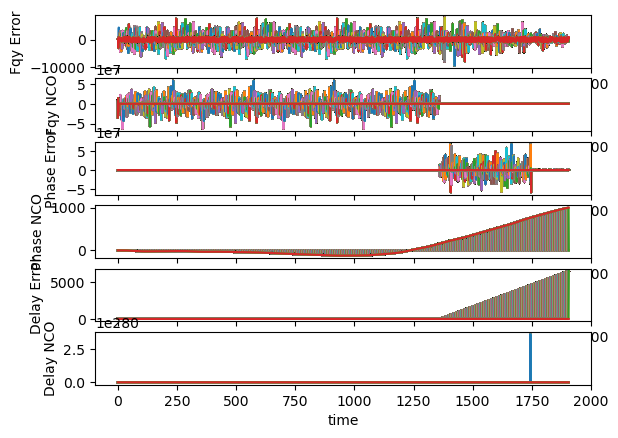

In [10]:
state = "ACQ"

for istep in range(numSteps):

    waveform = data[istep*samplePerStep: (istep+1)*samplePerStep]
    
    # Perform acquisition once from cold-start
    if (istep+1)*timeStep >= acqIntegTime and state == "ACQ":
        acqBuffer = data[0: (istep+1)*samplePerStep]
        acqBufferLen = len(acqBuffer)

        # Acqusition doppler search space
        fMin = -25000
        fMax = 25000
        fStep = 200
        fSearch = np.arange(fMin, fMax+fStep, fStep)

        tracker = []
        satVis = 0
        
        # Perform acquisition for each satellite
        for prnId in satId:
            status, codePhase, doppler, peakMetric = navs.navic_pcps_acquisition(
                                            acqBuffer, 
                                            codeTable[np.arange(0, acqBufferLen)%codeTableSampCnt, prnId-1], 
                                            sampleRate, 
                                            fSearch,
                                            threshold=2,
                                            relative_peak=True
                                        )   
            delaySamp = codePhase
            codePhase = (codePhase % codeTableSampCnt)/(sampleRate/codeFreqBasis)

            if(status):
                print(f"Acquisition results for PRN ID {prnId}\n Status:{status} Doppler:{doppler} Delay/Code-Phase:{delaySamp}/{codePhase} Peak-Metric:{peakMetric}")

            state = "TRK"

            # If a satellite is visible, initialize tracking loop
            if(status == True):
                satVis += 1

                tracker.append(navs.NavicTracker())
                tracker[-1].SampleRate = sampleRate
                tracker[-1].CenterFrequency = 0
                tracker[-1].PLLNoiseBandwidth = PLLNoiseBandwidth
                tracker[-1].FLLNoiseBandwidth = FLLNoiseBandwidth
                tracker[-1].DLLNoiseBandwidth = DLLNoiseBandwidth
                tracker[-1].PLLIntegrationTime = round(PLLIntegrationTime*1e3)
                tracker[-1].PRNID = prnId
                tracker[-1].InitialDopplerShift = doppler
                tracker[-1].InitialCodePhaseOffset = codePhase
                tracker[-1].setupImpl()
                tracker[-1].resetImpl()

            trackDataShape = (numSteps*round(PLLIntegrationTime*1e3), satVis)
            y = np.empty(trackDataShape, dtype=np.complex_)
            fqyerr = np.empty(trackDataShape)
            fqynco = np.empty(trackDataShape)
            pherr = np.empty(trackDataShape)
            phnco = np.empty(trackDataShape)
            delayerr = np.empty(trackDataShape)
            delaynco = np.empty(trackDataShape)

    # Perform tracking for visible satellites
    if(state == "TRK"):
        for i in range(satVis):
            y[istep, i], fqyerr[istep, i], fqynco[istep, i], pherr[istep, i], phnco[istep, i], delayerr[istep, i], delaynco[istep, i] = tracker[i].stepImpl(waveform)
        plt.subplot(6,1,1)
        plt.plot(fqyerr[:,i])
        #plt.ylim([0,0.05])
        plt.xlabel('time') ; plt.ylabel('Fqy Error')
    
        plt.subplot(6,1,2)
        plt.plot(fqynco[:,i])
        #plt.ylim([0,0.05])
        plt.xlabel('time') ; plt.ylabel('Fqy NCO')

        plt.subplot(6,1,3)
        plt.plot(pherr[:,i])
        #plt.ylim([0,0.05])
        plt.xlabel('time') ; plt.ylabel('Phase Error')

        plt.subplot(6,1,4)
        plt.plot(phnco[:,i])
        #plt.ylim([0,0.05])
        plt.xlabel('time') ; plt.ylabel('Phase NCO')

        
        plt.subplot(6,1,5)
        plt.plot(delayerr[:,i])
        #plt.ylim([0,0.05])
        plt.xlabel('time') ; plt.ylabel('Delay Error')
    
        plt.subplot(6,1,6)
        plt.plot(delaynco[:,i])
        #plt.ylim([0,0.05])
        plt.xlabel('time') ; plt.ylabel('Delay NCO')
        print(delayerr[-1])
        print(len(delayerr[-1]))

## Tracking Results

Prompt I branch:
 [1. 1. 1. ... 0. 0. 1.]
Prompt I branch inverted:
 [0. 0. 0. ... 1. 1. 0.]


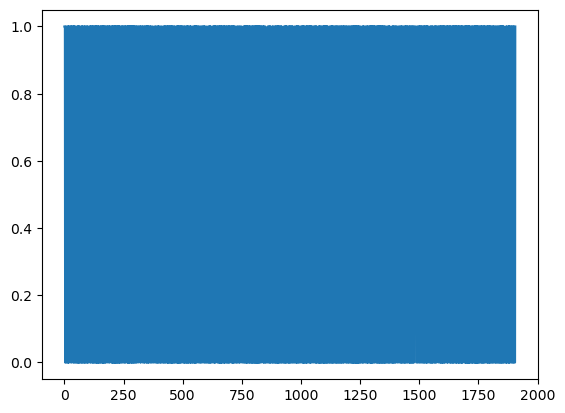

In [8]:
resultId = tracker[0].PRNID
satIdx = list(satId).index(resultId)

mapbit = lambda y: np.piecewise(np.imag(y), [np.imag(y) < 0, np.imag(y) >= 0], [0, 1])
mapbitinv = lambda y: np.piecewise(np.imag(y), [np.imag(y) < 0, np.imag(y) >= 0], [1, 0])

print("Prompt I branch:\n", mapbit(y[:, satIdx]))
print("Prompt I branch inverted:\n", mapbitinv(y[:, satIdx]))

plt.plot(mapbit(y[:, satIdx])[:])
plt.show()